In [3]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import emoji

import transformers
from transformers import AutoModel, BertTokenizerFast,AdamW
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
device = torch.device("cuda")

[nltk_data] Downloading package punkt to
[nltk_data]     /usr4/cs640g/ammar977/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr4/cs640g/ammar977/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr4/cs640g/ammar977/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
folder_path = "./Data Twitter/Train/"
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('txt'):
        path = os.path.join(folder_path,filename)
        df = pd.read_csv(path,sep='\t',header=None)
        df = df.drop(columns=[df.columns[0],df.columns[3]])
        dfs.append(df)

df_train = pd.concat(dfs)
df_train.columns = ['text','label']
df_train['label_numeric'] = df_train['label'].astype('category').cat.codes

print('total train samples : ',len(df_train))
print(df_train['label'].value_counts())

class_mapping = list(df_train['label'].astype('category').cat.categories)

total train samples :  3613
fear       1147
anger       857
joy         823
sadness     786
Name: label, dtype: int64


In [6]:
folder_path = "./Data Twitter/Dev/"
dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith('txt'):
        path = os.path.join(folder_path,filename)
        df = pd.read_csv(path,sep='\t',header=None)
        df = df.drop(columns=[df.columns[0],df.columns[3]])
        dfs.append(df)

df_dev = pd.concat(dfs)
df_dev.columns = ['text','label']
df_dev['label_numeric'] = df_dev['label'].astype('category').cat.codes

In [7]:
def preprocess_bert(tweet):
    # lower 
    tweet = tweet.lower()
    # remove http
    tweet =  re.sub(r"http\S+", "", tweet)
    # remove usernames
    tweet = ' '.join(re.sub("(@[a-z0-9_.]+)", "", tweet).split())
    # removal of hashtag
    tweet = tweet.replace('#','')
    # rempval of 'RT'
    tweet = tweet.replace('rt','')
    
    return tweet

In [8]:
train_text = df_train['text'].apply(preprocess_bert).tolist()
test_text = df_dev['text'].apply(preprocess_bert).tolist()

In [15]:
train_labels = df_train['label_numeric'].tolist()
test_labels = df_dev['label_numeric'].tolist()

In [10]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<AxesSubplot:>

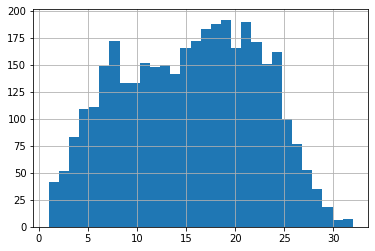

In [11]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [16]:
max_length = 30
tokens_train = tokenizer.batch_encode_plus(train_text,max_length = max_length,pad_to_max_length=True,truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text,max_length = max_length,pad_to_max_length=True,truncation=True)

In [17]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [18]:
batch_size = 64

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [19]:
# Freeze pre trained layers
for param in bert.parameters():
    param.requires_grad = False

In [44]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert 
        self.dropout = nn.Dropout(0.2)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.dropout2 = nn.Dropout(0.1)
        self.relu2 =  nn.ReLU()
        self.fc2 = nn.Linear(512,128)
        self.dropout3 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128,4)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        
        _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x


In [45]:
model_bert = BERT_Arch(bert)
model_bert = model_bert.to(device)

optimizer = AdamW(model_bert.parameters(),lr = 1e-5)
cross_entropy_loss  = nn.NLLLoss()

In [46]:
def train():
  
    model_bert.train()

    total_loss, total_accuracy = 0, 0

    total_preds=[]

    for step,batch in enumerate(train_dataloader):

        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model_bert.zero_grad()        

        # get model predictions for the current batch
        preds = model_bert(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy_loss(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds


def evaluate():
  
    # deactivate dropout layers
    model_bert.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(test_dataloader):

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model_bert(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy_loss(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(test_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [51]:
# best_valid_loss = float('inf')
epochs = 100

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, _ = train()
    
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_bert.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 100

Training Loss: 1.212
Validation Loss: 1.259

 Epoch 2 / 100

Training Loss: 1.208
Validation Loss: 1.275

 Epoch 3 / 100

Training Loss: 1.208
Validation Loss: 1.270

 Epoch 4 / 100

Training Loss: 1.208
Validation Loss: 1.280

 Epoch 5 / 100

Training Loss: 1.210
Validation Loss: 1.274

 Epoch 6 / 100

Training Loss: 1.209
Validation Loss: 1.256

 Epoch 7 / 100

Training Loss: 1.206
Validation Loss: 1.266

 Epoch 8 / 100

Training Loss: 1.211
Validation Loss: 1.259

 Epoch 9 / 100

Training Loss: 1.206
Validation Loss: 1.277

 Epoch 10 / 100

Training Loss: 1.199
Validation Loss: 1.265

 Epoch 11 / 100

Training Loss: 1.202
Validation Loss: 1.265

 Epoch 12 / 100

Training Loss: 1.197
Validation Loss: 1.267

 Epoch 13 / 100

Training Loss: 1.207
Validation Loss: 1.260

 Epoch 14 / 100

Training Loss: 1.203
Validation Loss: 1.268

 Epoch 15 / 100

Training Loss: 1.204
Validation Loss: 1.272

 Epoch 16 / 100

Training Loss: 1.205
Validation Loss: 1.263

 Epoch 17 / 100


In [52]:
with torch.no_grad():
    preds = model_bert(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds,target_names=class_mapping))

              precision    recall  f1-score   support

       anger       0.43      0.29      0.34        84
        fear       0.41      0.62      0.50       110
         joy       0.49      0.53      0.51        79
     sadness       0.32      0.18      0.23        74

    accuracy                           0.42       347
   macro avg       0.41      0.40      0.39       347
weighted avg       0.41      0.42      0.40       347

